# Movie Genre Identifier

This is an NLP (Natural Language Processing) project. The objective of this project is to build a model that predicts the genre of a movie by taking the movie's description as input. The dataset for this project was produced by merging three different movies datasets collected from Kaggle. Every movie in the dataset has a title, a description and one or more genres. In this notebook, Naive Bayes model was trained and tested on the dataset to predict the genres of the movies.

**Overview of the Cleaned Dataset**
- Total Movies: 4000
- Total Genres: 5
- Oldest Movie in the dataset is The Cabinet of Dr. Caligari from 1920
- Latest Movie in the dataset is The Gray Man from 2022

**Visual Representation of the Model**
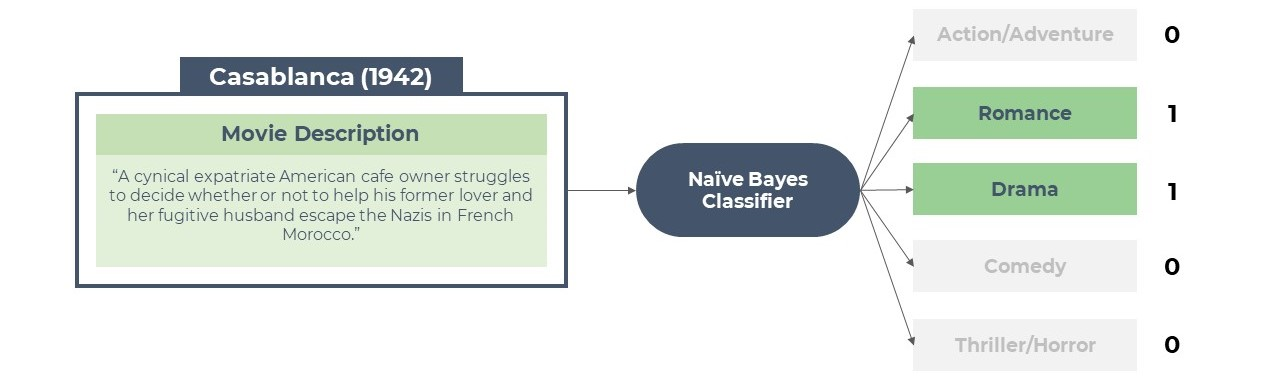

### Importing Libraries and Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
df_dtm = pd.read_csv("/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP/Document-term Matrix.csv")

### Building the Naive Bayes Classifier

In [ ]:
class NaiveBayesClassifier():

    def __init__(self, laplace_smoothing_alpha):
        self.alpha = laplace_smoothing_alpha

    def GetPriorProbability(self,Y):
        prior_probability= Y.value_counts(normalize=True, ascending=True)
        return dict(prior_probability)

    def GetLikelihood(self,X,Y):
        data = pd.concat([X,Y], axis=1)
        features = list(X.columns)
        target_variable = list(data.columns)[-1]
        labels = list(Y.unique())

        WordCountsByLabel = data.groupby(target_variable).sum()
        WordCountsByLabel.reset_index(inplace=True)

        TotalWordsByLabel = {target_variable : list(WordCountsByLabel[target_variable].unique()), "Total Words":list(WordCountsByLabel.sum(axis=1))}
        TotalWordsByLabel = pd.DataFrame(TotalWordsByLabel)

        likelihoods = {}
        for label in labels:
            df_temp = WordCountsByLabel[WordCountsByLabel[target_variable]==label][features]+self.alpha
            total_words = df_temp.sum(axis=1)
            likelihoods[label] = df_temp/int(total_words)

        return dict(likelihoods)


    def Classify(self, X_train, Y_train, X_test):
        X_test.reset_index(inplace=True, drop=True)
        features = list(X_test.columns)
        labels = list(Y_train.unique())

        prior_probabilities = self.GetPriorProbability(Y_train)
        likelihoods = self.GetLikelihood(X_train,Y_train)
        predictions = []

        for row in range(0,len(X_test)):
            df_temp = X_test.loc[row:row, :]
            words = list(df_temp.loc[:,(df_temp!=0).any(axis=0)].columns) #Discarding words that do not appear in the description

            posterior_probabilities = {}
            for label in labels:
                posterior_probabilities[label] = prior_probabilities[label]
                for word in words:
                    posterior_probabilities[label] = posterior_probabilities[label]*float(likelihoods[label][word])
            predictions.append(max(posterior_probabilities, key=posterior_probabilities.get))
        return predictions

## Fitting and Testing the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score confusion_matrix, ConfusionMatrixDisplay

from sklearn.naive_bayes import BernoulliNB

In [ ]:
X = df_dtm.iloc[:,:-5]
Y = df_dtm.iloc[:,-5:]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.15, random_state=41)

In [ ]:
NB = NaiveBayesClassifier(laplace_smoothing_alpha=2)

In [ ]:
for genre in Y_train.columns:
    predictions = NB.Classify(X_train, Y_train[genre], X_test)
    print(f"Accuracy score for {genre} movies: {accuracy_score(predictions, Y_test[genre])*100}%")

Accuracy score for Action/Adventure movies: 78.83333333333333%
Accuracy score for Romance movies: 80.83333333333333%
Accuracy score for Drama movies: 65.16666666666666%
Accuracy score for Comedy movies: 75.33333333333333%
Accuracy score for Thriller/Horror movies: 76.5%


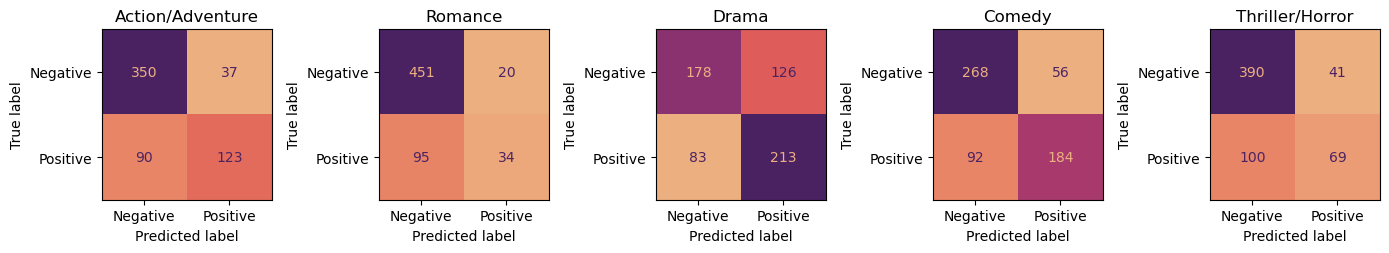

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(14,6))
for index, genre in enumerate(Y_train.columns):
    predictions = NB.Classify(X_train, Y_train[genre], X_test)
    cm = confusion_matrix(list(Y_test[genre]), predictions)  # Change variable name to 'cm'
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    cm_display.plot(colorbar=False, cmap="flare", ax=axs[index])
    axs[index].set_title(genre)
    plt.tight_layout()

# The End